In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import multivariate_normal
from utils import randncor

# Исследование непараметрических алгоритмов оценивания плотности распределения случайной величины: метод Парзена <a class="tocSkip">

Вычислить абсолютную ошибку оценивания плотности распределения случайного вектора в двумерном пространстве признаков при использовании оценки Парзена. Построить график зависимости ошибки оценивания от величины параметра оконной функции. Используйте одну из следующих оконных функций: гауссовская функция c использованием диагональной матрицы

# Постановка задачи

Задача оценки плотности распределения формулируется следующим образом.
Дана выборка $X = \big\{ x^{(1)}, ... ,x^{(N)}\big\}$- независимых и однинаково распределенных значений случайной величины __x__ из неизвестного распределения плотности $p(x)$. По этой выборке нужно найти некоторое приближение плотности $\tilde p(x) \approx p(x)$.

## Теория

Оценка плотности Парзена-Розенблатта в одномерном случае имеет вид

Гауссовская функция ядра имеет вид: $$K(u)= (2 \pi)^{\frac{-D}{2}} \exp\big(\frac{1}{2}\big(\frac{x-x_i}{h}\big)^2\big) $$.<br>
При подстановке в формулу оценки плотности получаем следующее выражение:<br>
$$P(x) = \frac{1}{n}\sum_{i=1}^{n} \frac{1}{h\sqrt{2\pi}} \exp\Big(\frac{1}{2}\big(\frac{x-x_i}{h}\big)^2 \Big)  $$

In [5]:
def gauss_diag_kernel(x,train,h):
    """Вычисление оценки плотности с использованием гауссовской оконной функции""" 
    
    n1,mx = x.shape
    n2,N = train.shape
    if n1==n2:
        n = n1
        fit = np.zeros([N,mx])
        for i in range(N):
            p_k = np.zeros([n,mx])
            mx_i = np.tile(XN[:,i].reshape(-1,1),[1,mx])
            ro = np.sum((x-mx_i)**2,0)
            fit[i,:] = np.exp(-ro/(2*h**2))/((2*np.pi)**(n/2)*(h**n))
        if N>1:
            p_ = np.sum(fit,0)/N
        else:
            p_ = fit
    return p_

В качестве примера мы будем рассматривать трехкомпонентную смесь гауссовских случайных векторов, имеющих одинаковую матрицу ковариаций. Зададим следующие параметры:
- n - размерность векторов
- ps - вероятности появления СВ различных типов в смеси
- D - дисперсия элементов
- ro - коэффициент корреляции

In [273]:
n = 2
ps=[0.2,0.3,0.5]

D=0.2
ro=-np.log(0.7)
m1=np.array([0,0])
m2=np.array([1,0])
m3=np.array([0,1])
m= [m1,m2,m3]

In [236]:
C = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        C[i,j]=D*np.exp(-ro*abs(i-j))

        x1 = np.arange(-2,3,0.1) 
x2 = np.arange(-2,3,0.1) 
X1,X2 = np.meshgrid(x1,x2) 
x = np.vstack((X1.ravel(),X2.ravel()))
x_ = x.T

p = ps[0] * multivariate_normal.pdf(x_,m1,C) + \
    ps[1] * multivariate_normal.pdf(x_,m2,C) + \
    ps[2] * multivariate_normal.pdf(x_,m3,C)
pi = np.reshape(p,(len(x1),len(x2)))

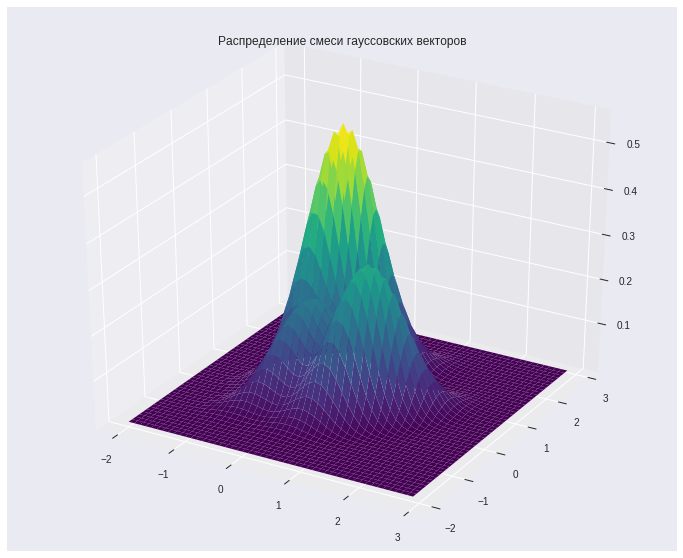

In [237]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, pi, cmap=plt.cm.viridis, linewidth=0.2);
ax.set_title('Распределение смеси гауссовских векторов');

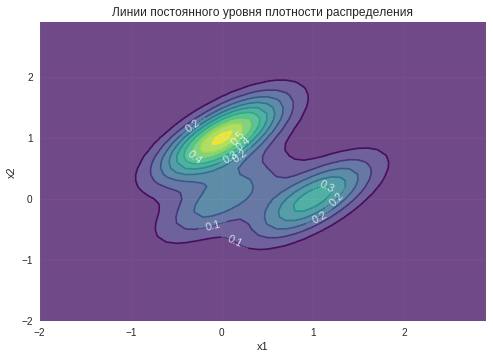

In [269]:
CS = plt.contourf(x1, x2, pi, 10, alpha=.75, cmap='viridis');
CS1 =plt.contour(x1, x2, pi, 10, alpha=.75, cmap='viridis');
plt.clabel(CS1, fmt='%2.1f', colors='w', fontsize=11)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Линии постоянного уровня плотности распределения');

Сгенерируем обучающую выборку размером N = 1000. Для генерации реализаций случайных векторов $x = Au$  будем использовать функцию randcor. К полученным значениям будем прибавлять математическое ожидание выбранное случайным образом. Так мы будем относить сгенерированные вектора к той или иной компоненте смеси.

In [242]:
N = 1000
XN = np.zeros([n,N])
for i in range(N):
    u = np.random.uniform()
    if u<ps[0]:
        t = 0
    elif u<ps[0]+ps[1]:
        t = 1
    else:
        t = 2
    XN[:,i] =(randncor(n,1,C) + m[t].reshape(-1,1)).T

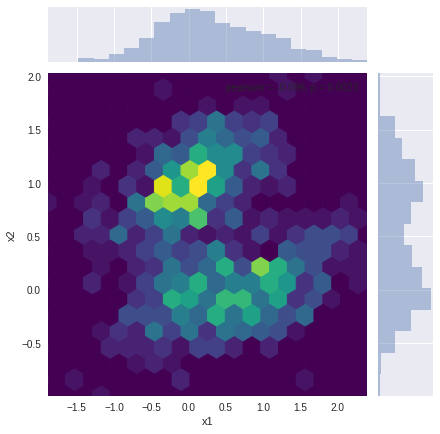

In [272]:
ax = sns.jointplot(x=XN[0,:], y=XN[1,:], kind='hex',cmap = 'viridis',);
ax.set_axis_labels('x1','x2');

In [244]:
h_N = np.arange(0.01,1.01,0.01)
errors = []
pvs=[]
for j in range(len(h_N)):
    h = h_N[j]
    p_ = gauss_diag_kernel(x,XN,h)
    pv = np.reshape(p_,(len(x1),len(x2)))
    pvs.append(pv)
    err = np.sum(np.abs(pi-pv))
    errors.append(err)

In [245]:
from IPython.display import HTML
HTML('<img src="prob-density.gif">')

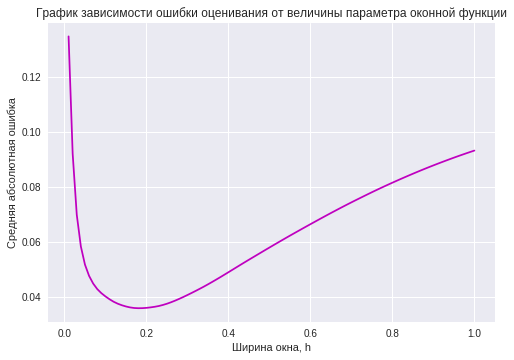

In [246]:
plt.plot(h_N,[e/N for e in errors],'m');
plt.xlabel('Ширина окна, h');
plt.ylabel('Cредняя абсолютная ошибка');
plt.title('График зависимости ошибки оценивания от величины параметра оконной функции');

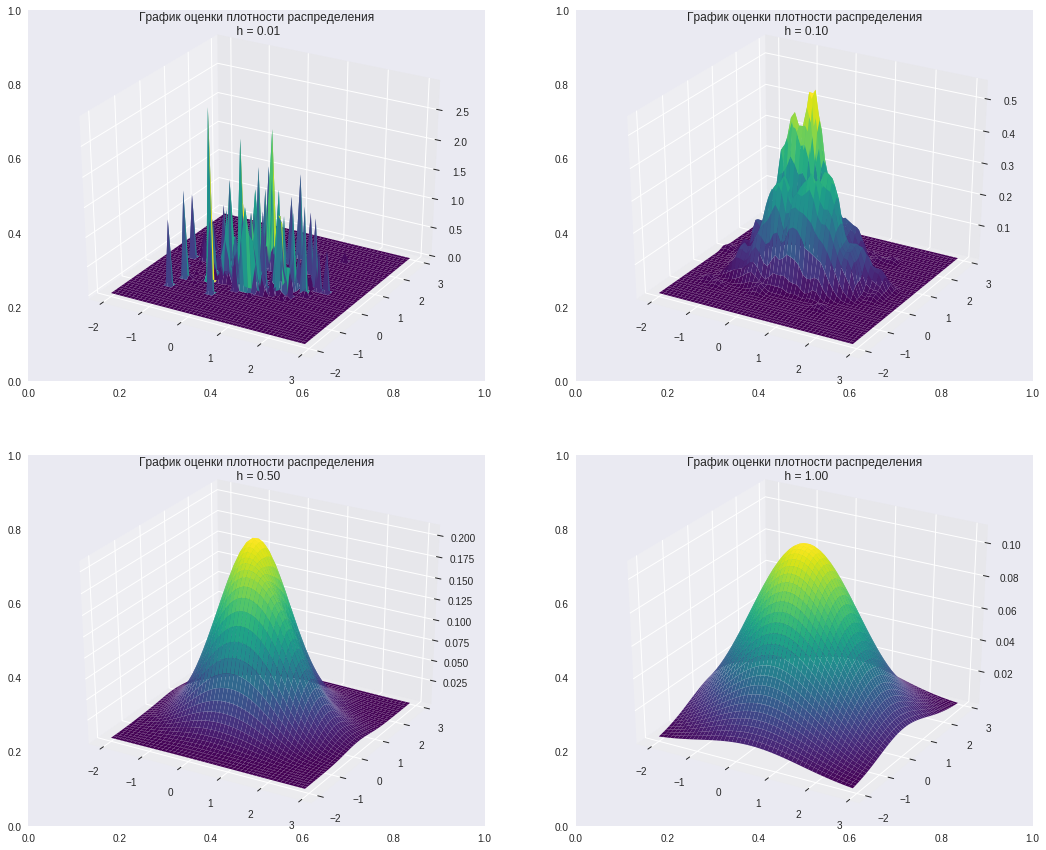

In [247]:
ind = [0,9,49,99]
h_N_selected = h_N[ind]
fig,axs = plt.subplots(ncols = 2,nrows = 2, figsize=(18,15))
for i, j in enumerate(ind):
    ax = fig.add_subplot(2,2,i+1,projection='3d')
    ax.plot_surface(X1, X2, pvs[j], cmap=plt.cm.viridis, linewidth=0.2);
    ax.set_title('График оценки плотности распределения\n h = {:0.2f}'.format(h_N_selected[i]));

Найдем ширину окна, при которой величина средней абсолютной ошибки является минимальной для данной выборки.

In [248]:
ind = errors.index(min(errors))
h_best = h_N[ind]
print('Ширина окна, при которой оценка плотности является наилучшей = {:0.2f}'.format(h_best))

Ширина окна, при которой оценка плотности является наилучшей = 0.18


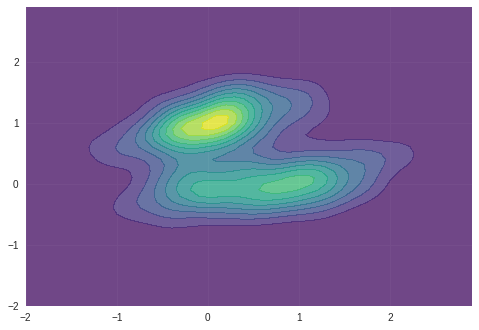

In [249]:
plt.contourf(x1, x2, pvs[ind], 10, alpha=.75, cmap='viridis');

In [250]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Surface(
        x = x1,
        y = x2,
        z=pvs[ind],
        colorscale='Viridis'
    )
]
layout = go.Layout(
    autosize= True,
    width=800,
    height=600,
     xaxis=dict(
        showgrid=True
    ),
    yaxis=dict(
        showgrid=True
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='prob-est-3d-surface')

In [251]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Surface(
        x = x1,
        y = x2,
        z=pi,
        colorscale='Viridis'
    )
]
layout = go.Layout(
    autosize= True,
    width=800,
    height=600,
     xaxis=dict(
        showgrid=True
    ),
    yaxis=dict(
        showgrid=True
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='prob-est-3d-surface')